In [1]:
from __future__ import division
import psycopg2
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
import numpy as np

from vectorizer_utility import get_tf_idf
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.metrics import confusion_matrix, roc_curve, auc, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity


pd.set_option('display.max_columns', 60)

# Read Data

In [48]:
conn = psycopg2.connect("dbname={} user={} host={}".format(dbname, user, host))
cur = conn.cursor()
SQL = '''
SELECT * 
FROM {} as ci
WHERE ci."listingInfo.startTime" >= '2017-01-15'
'''.format(TABLE_NAME)
df = pd.read_sql_query(sql=SQL, con=conn)

In [49]:
# yields true if there are no duplicate 'itemId'
if df['itemId'].shape[0] == len(df['itemId'].unique()):
    print 'No duplicate itemIds.'
else:
    print df['itemId'].shape[0], len(df['itemId'].unique())
    raise ValueError('Duplicate itemId in dataframe.')
    

No duplicate itemIds.


In [50]:
df.shape

(89604, 48)

# Cleaning

In [51]:
df['endListingType'] = ''

columns_to_drop = ['sellerInfo.sellerUserName','location','postalCode','paymentMethod','isMultiVariationListing','listingInfo.gift']
df = df.drop(labels=columns_to_drop, axis=1)

In [52]:
def create_end_listing_type_and_start_price(itemId, sellingState,listingType,currentPrice,startPrice,bidCount):
        
    if sellingState == 'EndedWithoutSales': # if item didnt sell, the listingType could not have changed
        endListingType = listingType 
        startPrice = currentPrice # item did not sell, so startPrice is = endPrice
        
    elif sellingState == 'EndedWithSales':
        
        if listingType == 'Auction': 
            
            bidCount = int(bidCount)
            
            if np.isnan(startPrice) and bidCount == 1:
                endListingType = 'FixedPrice' # auction was converted to BIN by user, and then sold
                startPrice = currentPrice # although technically the end price was != startPrice, it makes our lives easier to consider these listings as having been BIN the entire life of the listing
            
            elif np.isnan(startPrice) and bidCount > 1: # scrapy didn't grab anything, probably because invalid URL
                # Because if bidCount > 1, then there should be a bid history, and scrapy should have grabbed startPrice
                return ('Invalid URL', np.nan)
                
            elif np.isfinite(startPrice):
                endListingType = 'Auction'
                
                if np.isfinite(startPrice):
                    startPrice = startPrice
                        
        elif listingType == 'FixedPrice' or listingType == 'StoreInventory':
            endListingType = listingType
            startPrice = currentPrice 
    
    return pd.Series({'endListingType':endListingType,'startPrice':startPrice})
    


df[['endListingType','startPrice']] = df.apply(lambda row: create_end_listing_type_and_start_price(row['itemId'],\
                                                             row['sellingStatus.sellingState'],\
                                                             row['listingInfo.listingType'],\
                                                             row['sellingStatus.currentPrice.value'],\
                                                             row['startprice'],\
                                                             row['sellingStatus.bidCount']), \
         axis=1)

In [53]:
df[(df['sellingStatus.currentPrice.value'] >= 120) & (df['sellingStatus.currentPrice.value'] <= 180) & (df['listingInfo.listingType']=='Auction')].shape

(4156, 44)

In [62]:
df[df['viewItemURL']=="http://www.ebay.com/itm/Zed-2K-Stereo-Camera-/332172887849"]

,id,timestamp,itemId,topRatedListing,globalId,title,subtitle,country,primaryCategory.categoryId,primaryCategory.categoryName,secondaryCategory.categoryId,secondaryCategory.categoryName,pictureURLLarge,galleryURL,sellerInfo.feedbackRatingStar,sellerInfo.feedbackScore,sellerInfo.positiveFeedbackPercent,sellerInfo.topRatedSeller,shippingInfo.expeditedShipping,shippingInfo.shipToLocations,shippingInfo.shippingServiceCost.value,shippingInfo.oneDayShippingAvailable,shippingInfo.handlingTime,shippingInfo.shippingType,autoPay,returnsAccepted,viewItemURL,sellingStatus.currentPrice.value,startprice,endPrice,sellingStatus.bidCount,sellingStatus.sellingState,condition,condition.conditionId,condition.conditionDisplayName,listingInfo.listingType,listingInfo.bestOfferEnabled,listingInfo.buyItNowAvailable,listingInfo.buyItNowPrice.value,listingInfo.startTime,listingInfo.endTime,conditiondescription,endListingType,startPrice
30083,40347,2017-04-06 00:05:01.554000+00:00,332172887849,False,EBAY-US,Zed 2K Stereo Camera,GoPro case and extra batteries and remote,US,31388,Digital Cameras,None,None,http://i.ebayimg.com/00/s/MTIwMFgxNjAw/z/Ir0AA...,http://thumbs2.ebaystatic.com/m/m4TF2KtmMzEp39...,Turquoise,145,100.0,False,True,US,0.0,False,2.0,Free,False,False,http://www.ebay.com/itm/Zed-2K-Stereo-Camera-/...,120.0,NaN,None,1.0,EndedWithSales,None,3000,Used,Auction,False,False,NaN,2017-04-03 06:52:28-07:00,2017-04-03 06:55:13-07:00,NULL,FixedPrice,120.0


In [67]:
print df[df['itemId']==332172887849]['viewItemURL'].values[0]

http://www.ebay.com/itm/Zed-2K-Stereo-Camera-/332172887849


In [55]:
temp_df = df[df['endListingType']=='Invalid URL']
temp_df.head(3)

,id,timestamp,itemId,topRatedListing,globalId,title,subtitle,country,primaryCategory.categoryId,primaryCategory.categoryName,secondaryCategory.categoryId,secondaryCategory.categoryName,pictureURLLarge,galleryURL,sellerInfo.feedbackRatingStar,sellerInfo.feedbackScore,sellerInfo.positiveFeedbackPercent,sellerInfo.topRatedSeller,shippingInfo.expeditedShipping,shippingInfo.shipToLocations,shippingInfo.shippingServiceCost.value,shippingInfo.oneDayShippingAvailable,shippingInfo.handlingTime,shippingInfo.shippingType,autoPay,returnsAccepted,viewItemURL,sellingStatus.currentPrice.value,startprice,endPrice,sellingStatus.bidCount,sellingStatus.sellingState,condition,condition.conditionId,condition.conditionDisplayName,listingInfo.listingType,listingInfo.bestOfferEnabled,listingInfo.buyItNowAvailable,listingInfo.buyItNowPrice.value,listingInfo.startTime,listingInfo.endTime,conditiondescription,endListingType,startPrice
2450,3663,2017-04-05 05:55:10.156000+00:00,282328178619,False,EBAY-US,Nikon COOLPIX L20 10.0 MP Digital Camera - Dee...,An eBay Valet trusted partner listing (ebay.co...,US,31388,Digital Cameras,None,None,http://i.ebayimg.com/00/s/ODEwWDE0NDA=/z/pC8AA...,http://thumbs4.ebaystatic.com/m/mMZLPrXkMKuJ7x...,Yellow,20,96.5,False,False,US,0.00,False,1.0,Free,False,False,http://www.ebay.com/itm/Nikon-COOLPIX-L20-10-0...,23.38,NaN,None,6.0,EndedWithSales,None,3000,Used,Auction,False,False,NaN,2017-01-16 11:43:40-08:00,2017-01-21 11:43:40-08:00,None,Invalid URL,NaN
2848,50275,2017-04-06 02:54:21.246000+00:00,152482210949,False,EBAY-US,canon,Roberts Camera - Photo Industry Leader since 1...,US,31388,Digital Cameras,None,None,http://i.ebayimg.com/00/s/NjY3WDEwMDA=/z/wioAA...,http://thumbs2.ebaystatic.com/m/mLvAp7RBAxjlgM...,None,0,0.0,False,True,US,0.00,False,3.0,Calculated,False,False,http://www.ebay.com/itm/canon-/152482210949,158.17,NaN,None,7.0,EndedWithSales,None,3000,Used,Auction,False,False,NaN,2017-03-22 15:40:50-07:00,2017-03-29 15:40:50-07:00,None,Invalid URL,NaN
4137,6075,2017-04-05 05:58:29.510000+00:00,182466301696,False,EBAY-US,Kodak Easyshare P850 Digital Camera 5.1MP 12X...,An eBay Valet trusted partner listing (ebay.co...,US,31388,Digital Cameras,None,None,https://i.ebayimg.com/00/s/NzA1WDg3Mw==/z/pHMA...,http://thumbs1.ebaystatic.com/m/mA9P9cXWJ1T5pL...,Turquoise,108,95.4,False,False,US,9.99,False,3.0,Flat,False,False,http://www.ebay.com/itm/Kodak-Easyshare-P850-D...,26.00,NaN,None,5.0,EndedWithSales,None,3000,Used,Auction,False,False,NaN,2017-02-24 04:32:29-08:00,2017-03-03 04:32:29-08:00,None,Invalid URL,NaN


In [258]:
temp_df[temp_df['listingInfo.listingType']=='Auction']
temp_df[(temp_df['sellingStatus.currentPrice.value'] >= 120) & (temp_df['sellingStatus.currentPrice.value'] >= 120) & (temp_df['listingInfo.listingType']=='Auction') & (temp_df['conditiondescription']!=None) & (temp_df['conditiondescription']!='NULL')]

,id,timestamp,itemId,topRatedListing,globalId,title,subtitle,country,primaryCategory.categoryId,primaryCategory.categoryName,secondaryCategory.categoryId,secondaryCategory.categoryName,pictureURLLarge,galleryURL,sellerInfo.feedbackRatingStar,sellerInfo.feedbackScore,sellerInfo.positiveFeedbackPercent,sellerInfo.topRatedSeller,shippingInfo.expeditedShipping,shippingInfo.shipToLocations,shippingInfo.shippingServiceCost.value,shippingInfo.oneDayShippingAvailable,shippingInfo.handlingTime,shippingInfo.shippingType,autoPay,returnsAccepted,viewItemURL,sellingStatus.currentPrice.value,startprice,endPrice,sellingStatus.bidCount,sellingStatus.sellingState,condition,condition.conditionId,condition.conditionDisplayName,listingInfo.listingType,listingInfo.bestOfferEnabled,listingInfo.buyItNowAvailable,listingInfo.buyItNowPrice.value,listingInfo.startTime,listingInfo.endTime,conditiondescription,endListingType,startPrice
2848,50275,2017-04-06 02:54:21.246000+00:00,152482210949,False,EBAY-US,canon,Roberts Camera - Photo Industry Leader since 1...,US,31388,Digital Cameras,None,None,http://i.ebayimg.com/00/s/NjY3WDEwMDA=/z/wioAA...,http://thumbs2.ebaystatic.com/m/mLvAp7RBAxjlgM...,None,0,0.0,False,True,US,0.00,False,3.0,Calculated,False,False,http://www.ebay.com/itm/canon-/152482210949,158.17,NaN,None,7.0,EndedWithSales,None,3000,Used,Auction,False,False,NaN,2017-03-22 15:40:50-07:00,2017-03-29 15:40:50-07:00,None,Invalid URL,NaN
11139,47120,2017-04-06 00:07:10.527000+00:00,302240328116,False,EBAY-US,Nikon COOLPIX L840 Digital Camera,None,US,31388,Digital Cameras,None,None,http://i.ebayimg.com/00/s/MTIwMFgxNjAw/z/WssAA...,http://thumbs1.ebaystatic.com/m/mMxKhcCfCcS_EC...,PurpleShooting,91937,99.6,True,False,US,0.00,False,2.0,Free,False,True,http://www.ebay.com/itm/Nikon-COOLPIX-L840-Dig...,137.50,NaN,None,52.0,EndedWithSales,None,2000,Manufacturer refurbished,Auction,False,False,NaN,2017-03-02 12:02:45-08:00,2017-03-07 12:02:45-08:00,None,Invalid URL,NaN
11394,47121,2017-04-06 00:07:10.527000+00:00,122379203522,False,EBAY-US,Nikon COOLPIX L840 Digital Camera,None,US,31388,Digital Cameras,None,None,http://i.ebayimg.com/00/s/MTIwMFgxNjAw/z/oPAAA...,http://thumbs3.ebaystatic.com/m/mMxKhcCfCcS_EC...,PurpleShooting,91937,99.6,True,False,US,0.00,False,2.0,Free,False,True,http://www.ebay.com/itm/Nikon-COOLPIX-L840-Dig...,137.50,NaN,None,22.0,EndedWithSales,None,2000,Manufacturer refurbished,Auction,False,False,NaN,2017-03-02 12:02:31-08:00,2017-03-07 12:02:31-08:00,None,Invalid URL,NaN
12172,47631,2017-04-06 00:07:19.197000+00:00,192109153325,False,EBAY-US,"Nikon D200 Camera, MB-D200 Grip Only 15K Shutt...",None,US,31388,Digital Cameras,None,None,http://i.ebayimg.com/00/s/MTA2NlgxNjAw/z/n~YAA...,http://thumbs2.ebaystatic.com/m/m42LDvAqMnvcnp...,Turquoise,351,100.0,False,True,US,15.00,False,2.0,Flat,True,False,http://www.ebay.com/itm/Nikon-D200-Camera-MB-D...,142.50,NaN,None,9.0,EndedWithSales,None,3000,Used,Auction,False,False,NaN,2017-02-19 13:44:29-08:00,2017-02-26 13:44:29-08:00,None,Invalid URL,NaN
14271,53635,2017-04-06 02:55:35.933000+00:00,122330391808,False,EBAY-US,Samsung NX NX1000 20.3 MP Digital Camera Bundle,None,US,31388,Digital Cameras,None,None,http://i.ebayimg.com/00/s/MTA2N1gxNjAw/z/YdMAA...,http://thumbs1.ebaystatic.com/m/m9dvCXBIjCUjzB...,Blue,62,100.0,False,True,US,0.00,False,1.0,Free,True,False,http://www.ebay.com/itm/Samsung-NX-NX1000-20-3...,179.50,NaN,None,14.0,EndedWithSales,None,3000,Used,Auction,False,False,NaN,2017-01-28 18:58:54-08:00,2017-02-04 18:58:54-08:00,None,Invalid URL,NaN
30128,40401,2017-04-06 00:05:01.554000+00:00,302263559220,False,EBAY-US,Olympus E-510 IS 10 Mp 4/3rds Mt DSLR plus 40-...,Waterproof! Shockproof! Freezeproof! Dustproof!,US,31388,Digital Cameras,None,None,http://i.ebayimg.com/00/s/NDgwWDY0MA==/z/4tUAA...,http://thumbs1.ebaystatic.com/m/m_6rwpAaZMEs4H...,Turquoise,209,100.0,False,False,US,15.00,False,2.0,Flat,True,False,http://www.ebay.com/itm/Olympus-E-510-10-Mp-4-...,125.00,NaN,None,12.0,Ended

In [259]:
print temp_df[temp_df['itemId']==302263559220]['viewItemURL'].values[0]

http://www.ebay.com/itm/Olympus-E-510-10-Mp-4-3rds-Mt-DSLR-plus-40-150mm-lens-ONLY-/302263559220


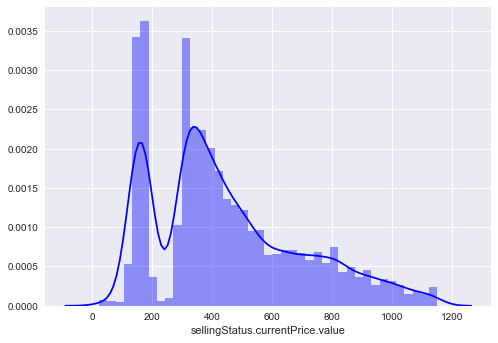

In [60]:
sns.distplot(temp_df['sellingStatus.currentPrice.value'], color='b')

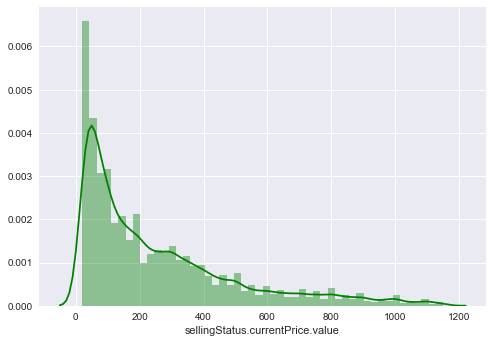

In [61]:
sns.distplot(df['sellingStatus.currentPrice.value'], color='g')

In [46]:
df = df[df['endListingType']!='Invalid URL']

In [47]:
df[(df['sellingStatus.currentPrice.value'] >= 120) & (df['sellingStatus.currentPrice.value'] <= 180) & (df['listingInfo.listingType']=='Auction')].shape

(2125, 44)

In [71]:
def bid_count_to_int(bidCount):
    if bidCount != bidCount:
        return -1
    else:
        return int(bidCount)


df['sellingStatus.bidCount'] = df['sellingStatus.bidCount'].apply(bid_count_to_int)

In [72]:
df['sold_state'] = df['sellingStatus.sellingState'].apply(lambda x: 1 if x=='EndedWithSales' else 0)

In [73]:
true_false_col = ['topRatedListing','shippingInfo.expeditedShipping','shippingInfo.oneDayShippingAvailable',
                 'autoPay','returnsAccepted',
                  'listingInfo.bestOfferEnabled','listingInfo.buyItNowAvailable']
for col in true_false_col:
    df[col] = df[col].apply(lambda x: 0 if x==False else 1)

In [74]:
df['conditiondescription'] = df['conditiondescription'].apply(lambda x: '' if x=='NULL' else x)

In [75]:
df['conditionAvailable'] = df['conditiondescription'].apply(lambda x: 1 if x!='' else 0)

In [76]:
df['endPrice'] = df['sellingStatus.currentPrice.value']

In [77]:
# auctions_w_bin = df[df['endListingType']=='AuctionWithBIN'].reset_index() # these didn't sell 
auctions = df[df['endListingType']=='Auction'].reset_index()
# fixed_price = df[df['endListingType']=='FixedPrice'].reset_index()
# store_inventory = df[df['endListingType']=='StoreInventory'].reset_index()

In [78]:
print 'total listings:', df.shape[0]
# print 'num AuctionWithBIN listings', auctions_w_bin.shape[0]
print 'num Auction listings:', auctions.shape[0]
# print 'num FixedPrice listings:', fixed_price.shape[0]
# print 'num StoreInventory listings:', store_inventory.shape[0]

total listings: 89604
num Auction listings: 18359


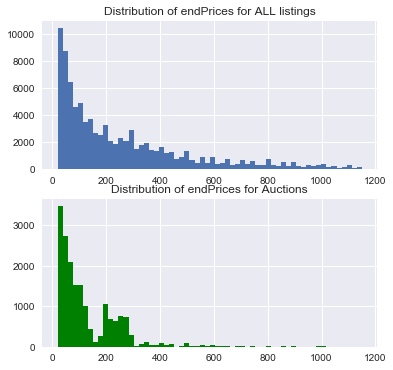

In [79]:
fix, axarr = plt.subplots(2, figsize=(6,6))
axarr[0].hist(df['endPrice'].values, bins=60);
axarr[0].set_title('Distribution of endPrices for ALL listings')
axarr[1].hist(auctions['endPrice'].values, bins=60, color='g');
axarr[1].set_title('Distribution of endPrices for Auctions')

In [81]:
# Use the conditionDisplayName if conditiondescription is empty
auctions['conditionCombined'] = ''
auctions['conditionCombined'] = auctions.apply(lambda x: x['condition.conditionDisplayName'] if (x['conditiondescription']=='' or x['conditiondescription']==None ) else x['conditiondescription'], axis=1)

Split up dataframe into feature subsets 

In [82]:
# Use startPrice, title (vectorized), conditionDisplayName (one-hot-encoded)
auction_condition_dummies = pd.get_dummies(data=auctions['condition.conditionDisplayName'])

start_price = auctions['startPrice']

titles = auctions['title']

sold = auctions['sold_state']

condition_combined = auctions['conditionCombined']

end_price = auctions['endPrice']

In [83]:
from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer

def clean_text(doc, remove_stop_words=True, remove_digits=False, remove_punc=True, stem=False):
    
    # 1. Remove any HTML markup
    text = BeautifulSoup(doc).get_text()  
    
    # 2. Extract special negator like n't
    text = re.sub('n\'t', ' not', text)
    
    # 3. remove punctuation(except .-)
    if remove_punc:
        text = re.sub('[^a-zA-Z.\-\d]', ' ', text)
        
    if remove_digits:
        text = re.sub('[.\d]', ' ', text)
        
    # 4. Convert to lower case 
    text = text.lower()
        
    # 5. Remove stop words
    if remove_stop_words:
        stops = set(stopwords.words("english"))
        text = [w for w in text.split(' ') if not w in stops]
        text = ' '.join(text)
                
    # 6. apply Porter Stemming
    # probably don't need this
    if stem:
        stemmer = PorterStemmer()
        stemmer = LancasterStemmer()
        text = [stemmer.stem(w) for w in text.split(' ')]
        text = ' '.join(text)
        
    # 7. Remove extra white space
    text = re.sub(' +',' ', text)
        
    return text

In [84]:
clean_titles = []
for i,title in enumerate(titles.values):
    if (i+1)%5000==0:
        print 'cleaning #{} out of {} documents'.format(i+1,len(condition_combined))
    clean_titles.append(clean_text(title))

/Users/Naekid/anaconda3/envs/dsi/lib/python2.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 174 of the file /Users/Naekid/anaconda3/envs/dsi/lib/python2.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


cleaning #5000 out of 18359 documents
cleaning #10000 out of 18359 documents
cleaning #15000 out of 18359 documents


In [85]:
clean_conditions = []
for i,cond in enumerate(condition_combined):
    if (i+1)%5000==0:
        print 'cleaning #{} out of {} documents'.format(i+1,len(condition_combined))
    clean_conditions.append(clean_text(cond))

/Users/Naekid/anaconda3/envs/dsi/lib/python2.7/site-packages/bs4/__init__.py:219: UserWarning: "." looks like a filename, not markup. You shouldprobably open this file and pass the filehandle intoBeautiful Soup.
  'Beautiful Soup.' % markup)


cleaning #5000 out of 18359 documents
cleaning #10000 out of 18359 documents
cleaning #15000 out of 18359 documents


# Vectorizer

1. Vectorize new dataframe (BoW, TFIDF, shingles, sPacy) as vdf
2. Calculate similarity (Jaccard, Cosine), between listing1 and all other listings in vdf
3. Set a threshold for similairty so that only items OVER that threshold will be considered in the model, i.e. filter vdf so that we only are considering listings very similar to the original listing

In [86]:
vectorizer = TfidfVectorizer(ngram_range = (1,2),
                             min_df=10,
                             analyzer='word',
                             stop_words=None,
                             max_features=10000,
                            )

titles_matrix = vectorizer.fit_transform(clean_titles)

import operator
print sorted(vectorizer.vocabulary_.items(), key=operator.itemgetter(1), reverse=True)[:5]
titles_df = pd.DataFrame(titles_matrix.todense(), columns=vectorizer.vocabulary_.keys())

[(u'zuiko', 2876), (u'zs8 14', 2875), (u'zs8', 2874), (u'zs7', 2873), (u'zs5', 2872)]


In [244]:
# calculate cosine similarity for each title with respect to every other title

# For each title, scan through other titles
    # if the similarity score is > than a vertain threshold, 
        # increment a counter
    # when done scanning, save fhte value of counter - it's a metric for how popular that item is
    

In [124]:
cos_sim_X = cosine_similarity(titles_matrix)

In [126]:
cos_sim_X.shape

(18359, 18359)

In [146]:
sim_count = []
threshold = 0.999

for i in range(cos_sim_X.shape[0]):
    count = np.count_nonzero(cos_sim_X[i] > np.max(cos_sim_X[i])*threshold)
    sim_count.append(count)
    

In [150]:
np.max(sim_count)

53

In [269]:
print 'most popular listing index:',sim_count.index(53), ', with {} similar listings'.format(np.max(sim_count))

most popular listing index: 3080 , with 53 similar listings


In [157]:
auctions.ix[3080].title

'Sony Cyber-shot DSC-H300 20.1 MP Digital Camera - Black'

In [268]:
originalListingId = 3080
threshold = 0.95

simScoreThreshold = np.max(cos_sim_X[originalListingId])*threshold

sim_dict = {}

for i,listingSimScore in enumerate(cos_sim_X[originalListingId]):    
    if listingSimScore > simScoreThreshold: # if similarity score for a listing is within top X% similarity of all listings 
        sim_dict[i] = listingSimScore
        
similar_listing_indeces = sim_dict.keys()        

56


In [266]:
index = 3080
auctions.ix[index]
similar_items = pd.DataFrame({'title':auctions.ix[similar_listing_indeces].title,
                            'startPrice':auctions.ix[similar_listing_indeces].startPrice,
                            'endPrice':auctions.ix[similar_listing_indeces].endPrice,
                            'sold_state':auctions.ix[similar_listing_indeces].sold_state}, 
                            index = [similar_listing_indeces])

print similar_items.title.values

['Sony Cyber-shot DSC-H300 20.1 MP Digital Camera - Black'
 'Sony Cyber-shot DSC-H300 20.1 MP Digital Camera - Black'
 'Sony Cyber-shot DSC-H300 20.1 MP Digital Camera - Black'
 'Sony Cyber-shot DSC-H300 20.1 MP Digital Camera - Black (20161626)'
 'Sony Cyber-shot DSC-H300 20.1 MP Digital Camera - Black'
 'Sony Cyber-shot DSC-H300 20.1 MP Digital Camera - Black'
 'Sony Cyber-shot DSC-H300 20.1 MP Digital Camera - Black'
 'Sony Cyber-shot DSC-H300 20.1 MP Digital Camera - Black'
 'Sony Cyber-shot DSC-H300 20.1 MP Digital Camera - Black'
 'Sony Cyber-shot DSC-H300 20.1 MP Digital Camera - Black'
 'Sony Cyber-Shot DSC-H300 20.1 MP Digital Camera - Black'
 'Sony Cyber-shot DSC-H300 20.1 MP Digital Camera - Black'
 'Sony Cyber-shot DSC-H300 20.1 MP Digital Camera'
 'Sony Cyber-shot DSC-H300 20.1 MP Digital Camera - Black'
 'Sony Cyber-shot DSC-H300 20.1 MP Digital Camera - Black'
 'Sony Cyber-shot DSC-H300 20.1 MP Digital Camera - Black'
 'Sony Cyber-shot DSC-H300 20.1 MP Digital Camera - B

In [264]:
similar_items[similar_items['sold_state']==0].shape

(6, 4)

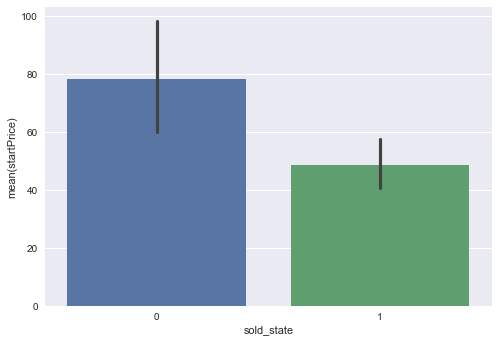

In [265]:
sns.barplot(x=similar_items['sold_state'], y=similar_items['startPrice'], estimator=np.mean)